# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

In [16]:
# Importar las Funciones
import sys
sys.path.append(r"D:\crist\OneDrive\Estudios\Mg Data Science_2024\Trimestre 5\Desarrollo de proyectos y productos de datos\Tareas\reestructuracion_y_evaluacion\src")

from datos import dataset 


## Leemos los datos

In [20]:
year = 2020
dataFrames = {}

# Eleguir el mes
def mes():
    while True:
        mes = input("Ingrese el número del mes analizar (01, 02, ..., 12): ")
        if mes in [f"{i:02d}" for i in range(1, 13)]:
            return mes
        else:
            print("El mes no corresponde, ingrese un número válido.")


while True:
    mes_input = mes()
    clave = f'{year}-{mes_input}'
    
    if clave in dataFrames:
        print(f"Estos datos ya estan cargados {clave} ")
    else:
        # Cargar los datos correspondiente al mes
        df = dataset.cargarData(year, mes_input)
        
        # Guardar en el diccionario
        dataFrames[clave] = df
        print(f"Datos cargados correctamente: {clave}") 
    
    preguntar = input("¿Desea cargar otro mes? (S/N)").lower()
    if preguntar != 's':
        break
    
print(f"Meses cargados, {list(dataFrames.keys())}")

Datos cargados correctamente: 2020-01
Datos cargados correctamente: 2020-02
Datos cargados correctamente: 2020-03
Meses cargados, ['2020-01', '2020-02', '2020-03']


### Información de los dataFrame

In [38]:
for x in dataFrames.values():
    display(x.head(3))

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-02-01 00:17:35,2020-02-01 00:30:32,1.0,2.6,1.0,N,145,7,1,11.0,0.5,0.5,2.45,0.0,0.3,14.75,0.0,None
1,1,2020-02-01 00:32:47,2020-02-01 01:05:36,1.0,4.8,1.0,N,45,61,1,21.5,3.0,0.5,6.30,0.0,0.3,31.60,2.5,None
2,1,2020-02-01 00:31:44,2020-02-01 00:43:28,1.0,3.2,1.0,N,186,140,1,11.0,3.0,0.5,1.00,0.0,0.3,15.80,2.5,None


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.7,1.0,N,88,255,1,22.0,3.0,0.5,2.00,0.0,0.3,27.80,2.5,None
1,2,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.0,1.0,N,193,193,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,None
2,1,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.1,1.0,N,246,90,1,6.0,3.0,0.5,1.95,0.0,0.3,11.75,2.5,None


## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [39]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [40]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [ ]:
target_col = "high_tip"

dataFrames_train = {}

for key, df in dataFrames.items():
    dataFrames_train[key] = preprocess(df=df, target_col= target_col)

In [45]:
for key, df_train in dataFrames_train.items():
    print(f'Número de filas (\033[1m{key}\033[0m): {len(df_train)}, Tamaño: {df_train.memory_usage(deep=True).sum() / 1e9} GB')

Número de filas (2020-01): 6382762, Tamaño: 0.357434804 GB
Número de filas (2020-02): 6276854, Tamaño: 0.351503956 GB
Número de filas (2020-03): 2995357, Tamaño: 0.167740124 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [50]:
for key, df_train in dataFrames_train.items():
    # Tomamos sólo las primeras 100 000 filas
    subset = df_train.head(100000)
    
    # Reempelazar en el diccionario
    dataFrames_train[key] = subset

    print(f'Número de filas (\033[1m{key}\033[0m): {len(subset)}, Tamaño: {subset.memory_usage(deep=True).sum() / 1e9} GB')

Número de filas (2020-01): 100000, Tamaño: 0.005600132 GB
Número de filas (2020-02): 100000, Tamaño: 0.005600132 GB
Número de filas (2020-03): 100000, Tamaño: 0.005600132 GB


In [53]:
%%time

randomForest = {}


for key, df_train in dataFrames_train.items():
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
    randomForest[key] = rfc.fit(df_train[features], df_train[target_col])
    
    print(f"Modelo entrenado para '{key}'")

# Imprimir el dict de modelos
print("\nModelos guardados:")
for key, model in randomForest.items():
    print(f"- {key}: {model}")



Modelo entrenado para '2020-01'
Modelo entrenado para '2020-02'
Modelo entrenado para '2020-03'

Modelos guardados:
- 2020-01: RandomForestClassifier(max_depth=10)
- 2020-02: RandomForestClassifier(max_depth=10)
- 2020-03: RandomForestClassifier(max_depth=10)
CPU times: total: 27.2 s
Wall time: 46.3 s


## Calculamos las métricas en el conjunto de entrenamiento

In [63]:
# Calcular métricas por fold
resultados = []
for clave, model in randomForest.items():
    df_train = dataFrames_train[clave]
    
    X_train = df_train[features]
    y_true = df_train[target_col]
    
    y_pred = model.predict(X_train)
    y_prob = model.predict_proba(X_train)[:, 1]
    
    acc   = accuracy_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    roc   = roc_auc_score(y_true, y_prob)
    
    resultados.append({
        'clave':    clave,
        'Accuracy':   acc,
        'F1-score':   f1,
        'ROC AUC':    roc
    })

# Convertir la lista a un DataFrame
df_resultados = pd.DataFrame(resultados)

# Convertir a formato largo para graficar
results_long = df_resultados.melt(
    id_vars='clave',
    var_name='Métrica',
    value_name='Valor'
)


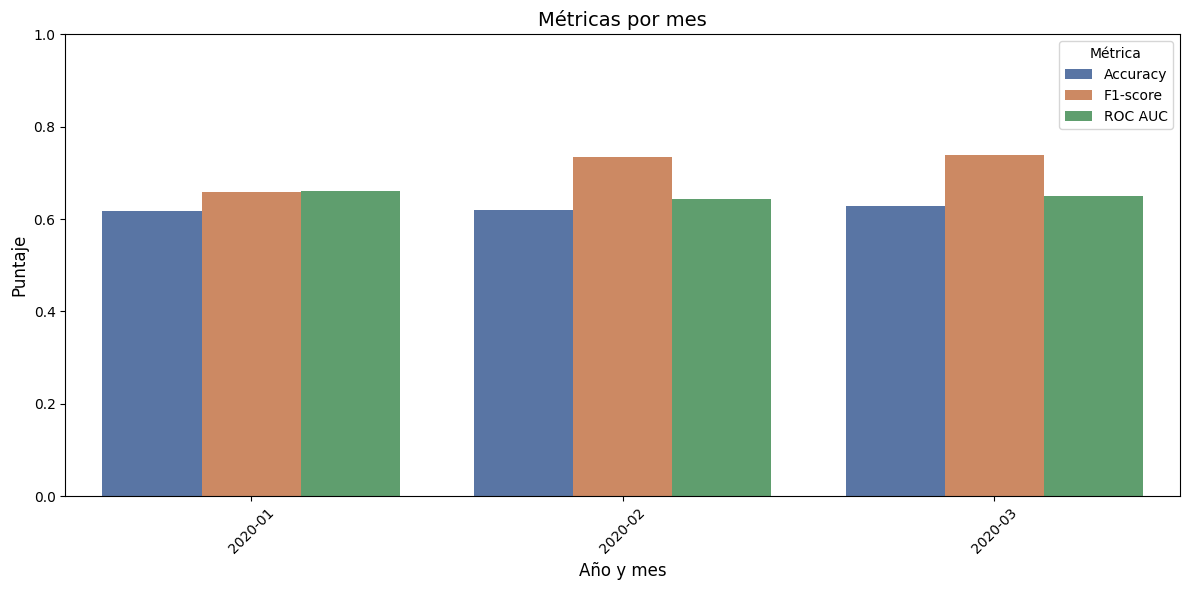

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_long,
    x='clave', y='Valor',
    hue='Métrica', palette='deep'
)
plt.ylim(0, 1)
plt.title('Métricas por mes', fontsize=14)
plt.ylabel('Puntaje', fontsize=12)
plt.xlabel('Año y mes', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

## Exportamos el modelo a un archivo

In [2]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

NameError: name 'rfc' is not defined

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

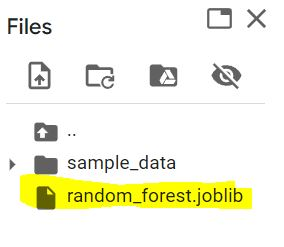

## Cargamos los datos de febrero 2020 (prueba)

In [15]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [16]:
loaded_rfc = joblib.load("random_forest.joblib")

In [17]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: total: 31.7 s
Wall time: 46.9 s


In [18]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.3527759877444044


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [19]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [20]:
taxi_test.head(1)[target_col].iloc[0]

np.int32(1)

In [21]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

d:\crist\OneDrive\Estudios\Mg Data Science_2024\Trimestre 5\Desarrollo de proyectos y productos de datos\Tareas\reestructuracion_y_evaluacion\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


np.float64(0.5481631086643783)

## Motivación: calculemos el desempeño para mayo de 2020

In [22]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')


F1: 0.515906934995257
